## Imports & Make it Pretty

In [213]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#make it pretty
plt.style.use('ggplot')

%matplotlib inline


## Data Data and ... More Data

In [70]:
# unless otherwise noted :  data sets are 2009 June 1 - 2019 May 31 = dataset 2009
df_2009 = pd.read_csv("/Users/sarahburgart/galvanize/week4-capstone-1/data/1749343.csv", low_memory=False)
df_1999 = pd.read_csv("/Users/sarahburgart/galvanize/week4-capstone-1/data/1749348.csv", low_memory=False)
df_1989 = pd.read_csv("/Users/sarahburgart/galvanize/week4-capstone-1/data/1749350.csv", low_memory=False)
# 1973 - 1979
df_1973 = pd.read_csv("/Users/sarahburgart/galvanize/week4-capstone-1/data/1979.csv", low_memory=False)
# 1964 - 1973 - no idea why they weren't in the other data sets ...
df_missing = pd.read_csv("/Users/sarahburgart/galvanize/week4-capstone-1/data/test.csv", low_memory=False)
# 1959 - 1964
df_1959 = pd.read_csv("/Users/sarahburgart/galvanize/week4-capstone-1/data/1969.csv", low_memory=False)
df_1949 = pd.read_csv("/Users/sarahburgart/galvanize/week4-capstone-1/data/1959.csv", low_memory=False)
# october 1943 - May 31 1949
df_1943 = pd.read_csv("/Users/sarahburgart/galvanize/week4-capstone-1/data/1949.csv", low_memory=False)


## Functions

In [237]:
# clean data set of null values for one column
# returns new dataframe

def no_more_null (df, column_not_null):
    df_mask = df[column_not_null].notnull()
    new_df = pd.DataFrame(df[df_mask])
    return new_df

def year_month_cols (df):
    df['year'] = pd.DatetimeIndex(df.loc[:,'DATE']).year
    df['month'] = pd.DatetimeIndex(df.loc[:,'DATE']).month
    return df

#### Do Stuff with the Data and Functions
## Take some columns from all Datasets and make 1 Dataset 

In [131]:
# to figure out what columns would be useful

# df_dropna = df_1943.dropna(axis=1,thresh=9000)
# df_dropna.shape
# df_dropna

In [72]:
# list of all datasets:
lst_1949_2019 = [df_1943, df_1949, df_1959, df_missing, df_1973, df_1989, df_1999, df_2009]

In [106]:
# list of all columns I want to include:
lst_cols = ["DATE","MonthlyMeanTemperature", "MonthlyMaximumTemperature", "MonthlyMinimumTemperature", "ShortDurationPrecipitationValue150", "DailyAverageDryBulbTemperature", "HourlyDryBulbTemperature", "TStorms", "MonthlyTotalSnowfall", "DailySnowfall", "DailySnowDepth"]


In [107]:
# get only cols I want
col_dfs = [x[lst_cols] for x in lst_1949_2019]

In [108]:
# combine all dfs into one df
all_dfs = pd.concat(col_dfs, axis=0)

In [114]:
# check that they all combined
all_dfs.shape
#all_dfs.head()

(525458, 11)

In [113]:
# remove null values and get year and month columns
all_dfs_no_null = no_more_null(all_dfs, "HourlyDryBulbTemperature")
#all_dfs_no_nulls = no_more_null(all_dfs, "DailyAverageDryBulbTemperature")
all_dfs_no_null.shape

# lost ~ 50,000 rows by doing no null Hourly Dry Bulb Temperature


(476267, 11)

In [242]:
# check for repetition



# didn't work - came back with only 12823 entries
# DatetimeIndex = all_dfs["DATE"]
# date_all_dfs = all_dfs[DatetimeIndex.duplicated(keep='first')]
# date_all_dfs.shape

# print(any(all_dfs_no_null['DATE'].duplicated()))

drop_duplicate_dates = (all_dfs_no_null.drop_duplicates("DATE")).copy()
drop_duplicate_dates.shape


(463700, 11)

In [243]:
# now we have all the data 10/1943 - 5/2019 duplicate dates removed, rows with null HourlyDryBulbTemperature removed

# want the average temperature 1/1952 - 12/1999 to use as the base for the temperature anomaly maths

# first need to make year and month columns
mega_dfs = year_month_cols(drop_duplicate_dates)

In [208]:
ba_df = pd.DataFrame(mega_dfs[mega_dfs["year"] < 2000 ])
b_df = pd.DataFrame(ba_df[ba_df["year"] > 1951])

# base_df == 1952 - 1999

# get mean of HourlyDryBulbTemperature
base_df = b_df.reset_index()

type(base_df.loc[0,"HourlyDryBulbTemperature"]) == float

#base_df[base_df["HourlyDryBulbTemperature"] 

base_df["HourlyDryBulbTemperature"].astype(float, errors='ignore').isna().sum()

0

In [218]:
base_df["HourlyDryBulbTemperature"].tail()
base_df.loc[261185,"HourlyDryBulbTemperature"]

'46'

In [223]:
base_df["HourlyDryBulbTemperature"].astype(int, errors='ignore')[261184] #.map(np.isreal)

'46'

In [233]:
indices = (~base_df["HourlyDryBulbTemperature"].astype(str).str[-1].str.isnumeric())
base_df.loc[indices,"HourlyDryBulbTemperature"] = base_df.loc[indices,"HourlyDryBulbTemperature"].str[:-1]

In [245]:
base_df["HourlyDryBulbTemperature"] = base_df["HourlyDryBulbTemperature"].astype(float)
base_mean = base_df["HourlyDryBulbTemperature"].mean()
base_mean

52.89116185400442

In [316]:
mega_dfs["HourlyDryBulbTemperature"] = mega_dfs["HourlyDryBulbTemperature"].map(lambda x:float(x) if x!="" else np.nan)

In [356]:
# convert to celsius b/c I want to compare anything with any other climate concerned scientist not in USA

In [374]:
mega_year = pd.DataFrame(mega_dfs[["year","HourlyDryBulbTemperature"]])
year_ms = mega_year.groupby("year")
year_means = pd.DataFrame(year_ms["HourlyDryBulbTemperature"].mean())

# (32°F − 32) × 5/9 = 0°C

year_means["mean temp in C"] = year_means["HourlyDryBulbTemperature"].map(lambda x:((x-32)*(5/9)))


# diff between base_mean and year_mean
year_means["raw_anomaly"] = year_means["mean temp in C"] - ((base_mean-32)*(5/9))

year_means = year_means.reset_index()

#take out 1943 and 2019 b/c they aren't full years
year_means = year_means.iloc[1:53,:]

# 2003 aka index 37 is also incomplete
year_means = year_means.drop(37)
year_means

,year,HourlyDryBulbTemperature,mean temp in C,raw_anomaly
1,1944,51.586045,10.881136,-0.725065
2,1948,50.481203,10.267335,-1.338866
3,1949,51.144603,10.635891,-0.970310
4,1950,50.970971,10.539429,-1.066772
5,1951,51.826350,11.014639,-0.591562
6,1952,51.866864,11.037147,-0.569054
7,1953,53.039963,11.688869,0.082668
8,1954,51.133805,10.629892,-0.976309
9,1955,49.597032,9.776129,-1.830072
10,1956,51.218085,10.676714,-0.929487


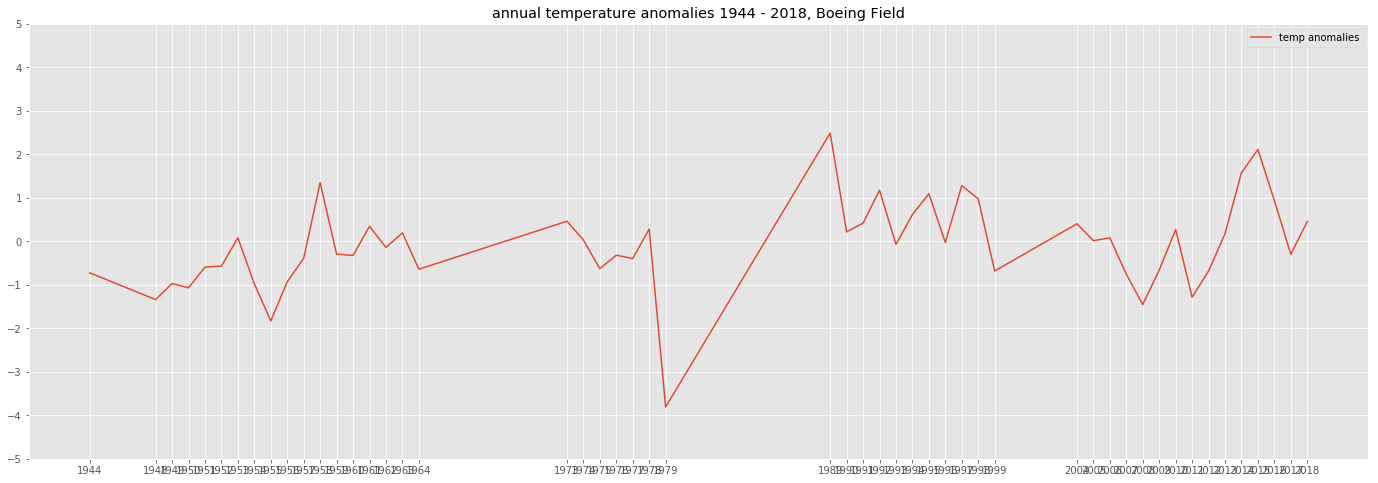

In [375]:
# plot temperature anomaly for 1944-2018

fig, ax = plt.subplots(1, 1, figsize=(24, 8))
ax.plot(year_means['year'],year_means["raw_anomaly"] , label = "temp anomalies")
ax.set_yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])

ax.set_xticks(year_means['year'])
ax.set_title("annual temperature anomalies 1944 - 2018, Boeing Field")
ax.legend(loc='best')

plt.show()

In [367]:
# row 37, year 2003 - -16 :()

In [386]:
#mega_dfs[mega_dfs["month"] == 8].count()
# do the anomalies to the right half vary significantly from the anomalies to the left?

In [ ]:
# is ratio of change in my set in my years == to the ratio of change in the paleo?